In [1]:
# Importando bibliotecas
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Carregando os dados
obitos = pd.read_csv("C:\\Users\\maste\\Downloads\\Python-Datasus-master\\Python-Datasus-master\\Obitos-Capitulo-CID10-2015-2020.csv", sep=';', index_col=0)
obito2020 = pd.read_csv("C:\\Users\\maste\\Downloads\\Python-Datasus-master\\Python-Datasus-master\\Obitos-Capitulo-CID10-2020.csv", sep=';')

In [5]:
# Gerando dicionário com descrições dos Capítulos
capitulos = {}
for linha in obito2020['Capítulo CID-10']:
    pos = linha.find('.')
    chave = linha[0:pos]
    valor = linha[pos + 1:]
    capitulos[chave] = valor.lstrip()
capitulos['Total'] = 'Nacional'

In [7]:
# Renomeando os capítulos no DataFrame obitos
alterar_cap = dict(zip(obitos.columns, capitulos.keys()))
obitos = obitos.rename(columns=alterar_cap)

In [9]:
# Transposição do DataFrame para facilitar a visualização
obitos = obitos.T

In [11]:
# Criando uma coluna "Total" como a soma de todas as causas
obitos['Total'] = obitos.sum(axis=1)

In [13]:
# Transformando o problema em classificação: criando categorias para o total de óbitos
bins = pd.qcut(obitos['Total'], q=3, labels=['Baixo', 'Médio', 'Alto'])
obitos['Categoria'] = bins

In [15]:
# Separando variáveis independentes e dependentes
X = obitos.drop(columns=['Total', 'Categoria'])  # Variáveis independentes
y = obitos['Categoria']  # Variável dependente

In [17]:
# Normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# Modelo Random Forest com GridSearch para otimização de hiperparâmetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_rf.fit(X_scaled, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [21]:
# Melhor modelo Random Forest
grid_best_rf = grid_rf.best_estimator_

In [23]:
# Modelo Naive Bayes
gnb = GaussianNB()
gnb.fit(X_scaled, y)

GaussianNB()


Modelo: Random Forest
Relatório de Classificação:

              precision    recall  f1-score   support

        Alto       1.00      1.00      1.00         7
       Baixo       1.00      1.00      1.00         7
       Médio       1.00      1.00      1.00         6

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



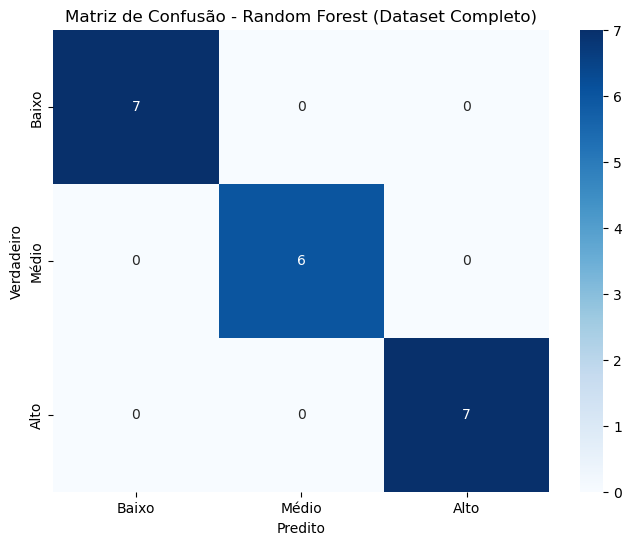


Modelo: Naive Bayes
Relatório de Classificação:

              precision    recall  f1-score   support

        Alto       1.00      0.86      0.92         7
       Baixo       1.00      1.00      1.00         7
       Médio       0.86      1.00      0.92         6

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20



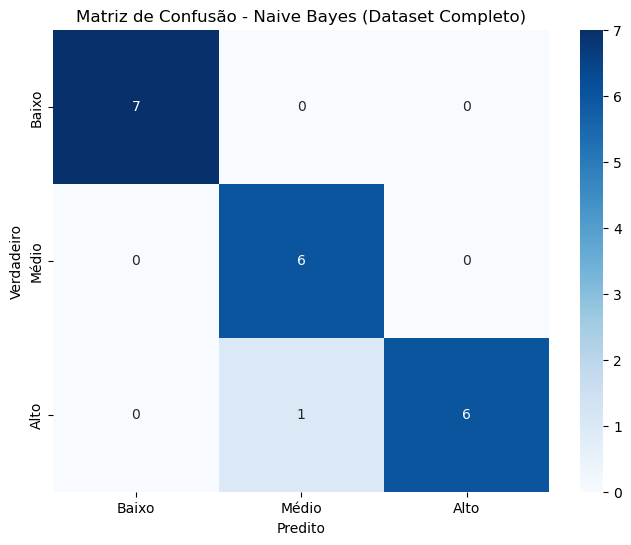

In [25]:
# Avaliação dos modelos
models = {
    'Random Forest': grid_best_rf,
    'Naive Bayes': gnb
}

for name, model in models.items():
    print(f"\nModelo: {name}")
    y_pred = model.predict(X_scaled)
    print("Relatório de Classificação:\n")
    print(classification_report(y, y_pred))

    # Matriz de confusão
    conf_matrix = confusion_matrix(y, y_pred, labels=['Baixo', 'Médio', 'Alto'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixo', 'Médio', 'Alto'], yticklabels=['Baixo', 'Médio', 'Alto'])
    plt.title(f"Matriz de Confusão - {name} (Dataset Completo)")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.show()

In [27]:
# Validação cruzada para Random Forest e Naive Bayes
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    print(f"\nValidação Cruzada - {name}:\n")
    print(f"Média: {scores.mean():.2f}, Desvio Padrão: {scores.std():.2f}")

# Comparando importância das variáveis no Random Forest
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': grid_best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nImportância das Variáveis no Random Forest:")
print(feature_importances)



Validação Cruzada - Random Forest:

Média: 0.75, Desvio Padrão: 0.22

Validação Cruzada - Naive Bayes:

Média: 0.90, Desvio Padrão: 0.12

Importância das Variáveis no Random Forest:
  Feature  Importance
3    2018    0.186389
4    2019    0.182318
2    2017    0.179116
0    2015    0.156909
1    2016    0.156082
5    2020    0.139186


C:\Users\maste\AppData\Local\Temp\ipykernel_23376\1369454055.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


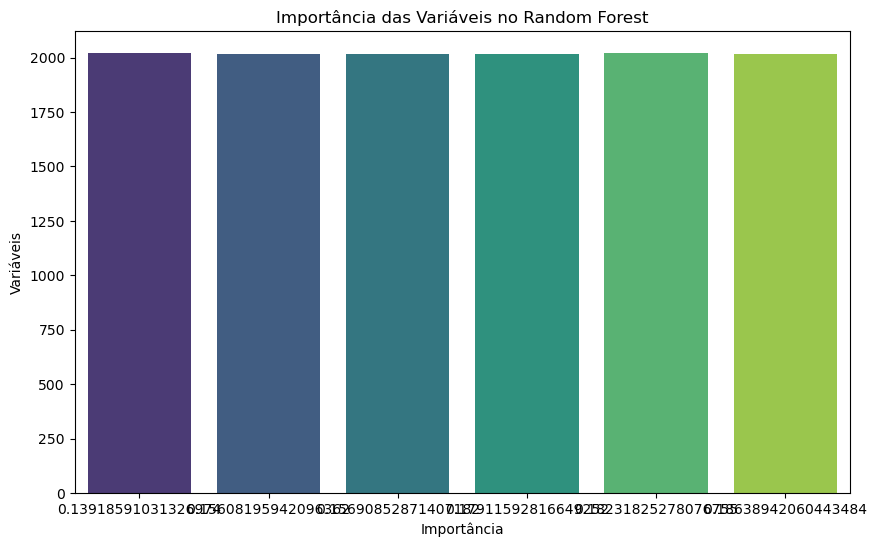

In [29]:
# Plotando as importâncias das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Importância das Variáveis no Random Forest')
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.show()